<a href="https://colab.research.google.com/github/higor-gomes93/ona_research/blob/main/AIHR_ONA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1) Libraries

In [170]:
# Libraries
!pip install pyvis dash dash_cytoscape
import pandas as pd
import random as rd
from random import randint
import numpy as np
import json
import os
import pyvis as pv
import networkx as nx
from pyvis.network import Network
import plotly.graph_objects as go
import dash
from dash import dcc
from dash import html
import dash_cytoscape as cyto
from dash.dependencies import Input, Output
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
from IPython.core.display import display, HTML

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [139]:
# Connection with Google Drive and Google Sheets
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials
from google.colab import drive 
from google.auth import default
drive.mount('/content/gdrive')
from gspread_dataframe import set_with_dataframe
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 2) Importing the Dataset

In [140]:
# Getting all the files
files = os.listdir('gdrive/My Drive/Área de Trabalho/Documentos/Datasets/facebook')

In [141]:
# Creating a function to get all the data
def get_raw_data(file):
    # Getting the raw data
    raw_data = []
    with open(file) as f:
        for line in f:
            items_list = line.split()
            raw_data.append(items_list)
    # Turning it into a dict
    raw_relations = []
    for i in raw_data:
        for j in range(1, len(i)):
            raw_relations.append((i[j], i[0]))
    return raw_relations

In [142]:
# Merging the relations
total_groups = []
for i in files:
    if i != 'facebook_combined.txt':
        relations = get_raw_data(f'gdrive/My Drive/Área de Trabalho/Documentos/Datasets/facebook/{i}')
        total_groups.extend(relations)

# Creating a dict
groups_dict = dict(total_groups)

In [143]:
# Importing the edges
with open("gdrive/My Drive/Área de Trabalho/Documentos/Datasets/facebook/facebook_combined.txt") as f:
    raw_edges = f.read().split("\n")

edges = []
for i in raw_edges:
    aux = i.split(" ")
    try:
        edges.append((aux[0], aux[1]))
    except:
        pass

In [144]:
# Creating a dataframe
dataset = pd.DataFrame(edges, columns = ['source_name', 'target_name'])

In [145]:
# Adding groups
source_groups = []
target_groups = []
for i in range(len(dataset)):
    try:
        source_groups.append(groups_dict[dataset.iloc[i]['source_name']])
    except:
        source_groups.append("no_circle")
    try:
        target_groups.append(groups_dict[dataset.iloc[i]['target_name']])
    except:
        target_groups.append("no_circle")

dataset['source_groups'] = source_groups
dataset['target_groups'] = target_groups

In [146]:
# Adding size
dataset['source_size'] = dataset['source_name'].apply(lambda x: len(dataset.loc[dataset['source_name'] == x]))
dataset['target_size'] = dataset['target_name'].apply(lambda x: len(dataset.loc[dataset['target_name'] == x]))

In [147]:
# Counting the edges
ona_relations = [(dataset.iloc[i]['source_name'], dataset.iloc[i]['target_name']) for i in range(len(dataset))]
edge_weight = [ona_relations.count(i) for i in ona_relations]

In [ ]:
# Adding the edge weights
dataset['edge'] = edge_weight

In [149]:
# Setting a new order
dataset = dataset[['source_name', 'source_size', 'source_groups', 'target_name', 'target_size', 'target_groups', 'edge']]

### 3) Graph Visualization

#### 3.1 PyVis

In [172]:
# Creating the graph object
graph = Network(height='1000px', width='100%', bgcolor='#111111', font_color='white', directed = False)
graph.barnes_hut(gravity = -80000, central_gravity=0.3, spring_length = 250, spring_strength=0.01, damping=0.09, overlap = 0)

In [ ]:
# Adding the data
for i in range(len(dataset)):
    source = dataset.iloc[i]['source_name']
    source_group = dataset.iloc[i]['source_groups']
    source_size = int(dataset.iloc[i]['source_size'])
    target = dataset.iloc[i]['target_name']
    target_group = dataset.iloc[i]['target_groups']
    target_size = int(dataset.iloc[i]['target_size'])
    weight = int(dataset.iloc[i]['edge'])

    graph.add_node(source, title = source, group = source_group, size = source_size)
    graph.add_node(target, title = target, group = target_group, size = target_size)
    graph.add_edge(source, target, width = weight, color = "#282828")

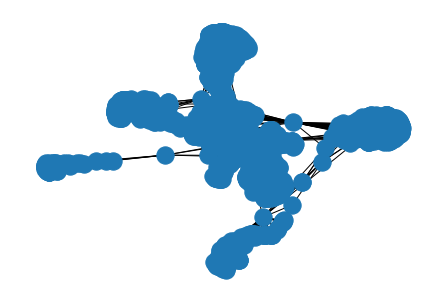

In [155]:
# Ploting
graph.toggle_physics(False)
graph.show('graph.html')
display(HTML('graph.html'))

#### 3.2) NetworkX

In [168]:
aux_dataset = dataset[['source_name', 'target_name']]
aux_dataset = aux_dataset.astype(int)
graph = nx.from_pandas_edgelist(aux_dataset, "source_name", "target_name")

(-0.9991880235075951,
 1.1078363832831382,
 -1.164599134027958,
 0.7322099342942238)

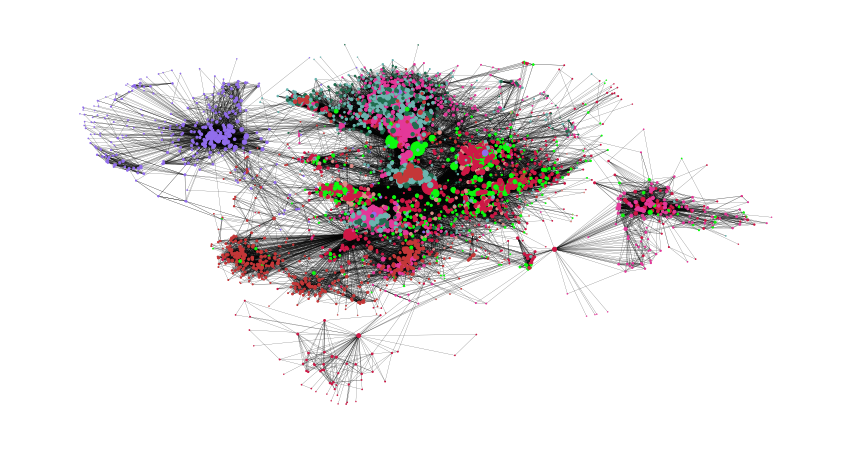

In [171]:
pos = nx.spring_layout(graph, iterations=15, seed=1721)
degree_centrality = nx.centrality.degree_centrality(graph)

node_size = [
    v * 1000 for v in degree_centrality.values()
]

colors = ["" for x in range(graph.number_of_nodes())]
for com in nx.community.asyn_fluidc(graph, 8, seed=0):
    color = "#%06X" % randint(0, 0xFFFFFF)  # creates random RGB color
    for node in list(com):
        colors[node] = color

plt.figure(figsize=(15, 8))
nx.draw_networkx(graph, pos=pos, node_size=node_size, node_color=colors, with_labels=False, width=0.15)
plt.axis("off")